In [1]:
from collections import Counter
import os
from glob import glob

from graphviz import Source
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import networkx as nx
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns


sns.set_style('white')
sns.set_context('notebook')

def plot_style(figsize=(12, 6), labelsize=20, titlesize=24, ticklabelsize=14, **kwargs):
   basic_style = {
       'figure.figsize': figsize,
       'axes.labelsize': labelsize,
       'axes.titlesize': titlesize,
       'xtick.labelsize': ticklabelsize,
       'ytick.labelsize': ticklabelsize,
       'axes.spines.top': False,
       'axes.spines.right': False,
       'axes.spines.left': False,
       'axes.grid': False,
       'axes.grid.axis': 'y',
   }
   basic_style.update(kwargs)
   return plt.rc_context(rc=basic_style)

blue = sns.xkcd_rgb['ocean blue']

In [2]:
def new_count_row(all_clone_names, clone_name=None):
    """ Create a DataFrame row with one entry per clone name. 
    
    If `clone_name` is not None, initialize that entry to 1.
    """
    row = pd.Series(data=0, index=all_clone_names)
    if clone_name is not None:
        row[clone_name] = 1
    return row

def dfs_clones_count(g, clones, all_clone_names, source_node):
    clones_count = pd.DataFrame({sample_name: new_count_row(all_clones, clone_name) for sample_name, clone_name in clones.items()})
    for pre_node, post_node, edge_label in nx.dfs_labeled_edges(g, source_node):
        if edge_label is not 'reverse' or pre_node == post_node: 
            continue
        pre_node_counter = clones_count.get(pre_node, new_count_row(all_clones))
        if post_node not in clones_count.columns:
            print('!! possible mutation in a leaf: not found', post_node)
            continue
        clones_count[pre_node] = pre_node_counter + clones_count[post_node]

    return clones_count

def purity(clones_count):
    return clones_count.div(clones_count.sum(axis=0), axis=1)

def get_root_node(t):
    root_nodes = [n for n,d in t.in_degree() if d==0]
    assert len(root_nodes) == 1
    root_node = root_nodes[0]
    return root_node

<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:14: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if edge_label is not 'reverse' or pre_node == post_node:


In [3]:
# Plot an example tree
#Source.from_file('../../../mt-SCITE/mt-SCITE_output/P9855/0.0001/0.0001_map0.gv')

## Clone map

In [4]:
data = pd.read_csv('../../data/YFV2001_clone_key/YFV2001_clone_key', sep = '\t')
data.head()

clones_map_raw = data.copy()

In [5]:
clones_map_raw.clone.value_counts()

149     20
118     18
107     16
122      8
108      6
143      4
bulk     1
Name: clone, dtype: int64

In [6]:
clones_map = dict(clones_map_raw[['tree_id', 'clone']].values)
all_clones = list(clones_map_raw.clone.unique())

In [7]:
n_samples_per_clone = clones_map_raw.clone.value_counts()
n_samples_per_clone

149     20
118     18
107     16
122      8
108      6
143      4
bulk     1
Name: clone, dtype: int64

## Load tree and pmat data

In [8]:
scite_input_path = '../../../mt-SCITE/mt-SCITE_output/YFV2001/stdout/'
scite_stdout_filenames = list(glob(os.path.join(scite_input_path, '*.txt')))
#scite_stdout_filenames


# Get log likelihood scores
experiments = []
lhood = []
n_trees = []
for filename in sorted(scite_stdout_filenames):
    name = os.path.basename(filename).split('-')[0].rsplit('.', 2)[0]
    experiments.append(name)
    experiments = [float(x) for x in experiments]
    file = open(filename, "r")
    for line in file:
        if 'best log score for tree:' in line:
            score = line.split('	')[1].rstrip()
            lhood.append(score)
            lhood = [float(x) for x in lhood]
        if 'opt tree' in line:
            n = line.split(' opt')[0].lstrip()
            n_trees.append(n)
            n_trees = [int(x) for x in n_trees]

In [9]:
experiments

[0.0001,
 0.0112,
 0.0223,
 0.0334,
 0.0445,
 0.0556,
 0.0667,
 0.0778,
 0.0889,
 0.1,
 0.2,
 0.22]

In [10]:
pmat_input_path = '../../data/YFV2001_matrix_output/'
pmats = list(glob(os.path.join(pmat_input_path, '*.csv')))
#pmats

# Get n mutations
n_mut = []
for filename in sorted(pmats):
    file = open(filename, "r")
    n = len(file.readlines())
    n_mut.append(n)

In [18]:
# Create df
samples = 73
performance = pd.DataFrame(experiments)
performance['lhood'] = lhood
performance['n trees'] = n_trees
performance['n mutations'] = n_mut
performance['lhood'] = performance['lhood'].astype(float)
#tree_data['lhood_mut'] = tree_data['best log score for tree']/tree_data['n mutations']
performance['entries'] = performance['n mutations']*samples
performance['lhood_entries'] = performance['lhood']/performance['entries']
performance = performance.rename(columns={0: 'error_rate'})
performance = performance.set_index('error_rate')
performance

,lhood,n trees,n mutations,entries,lhood_entries
error_rate,,,,,
0.0001,-14500.813514,11,453,33069,-0.438502
0.0112,-2249.536651,14,104,7592,-0.296304
0.0223,-1692.173115,2,63,4599,-0.367944
0.0334,-1195.242773,7,52,3796,-0.314869
0.0445,-925.220531,2,47,3431,-0.269665
0.0556,-865.138901,5,41,2993,-0.289054
0.0667,-832.854042,8,41,2993,-0.278267
0.0778,-810.212019,3,39,2847,-0.284584
0.0889,-820.883432,6,39,2847,-0.288333


In [19]:
error_rates = performance.index.tolist()
n_trees = performance['n trees'].tolist()
error_rates, n_trees

([0.0001,
  0.0112,
  0.0223,
  0.0334,
  0.0445,
  0.0556,
  0.0667,
  0.0778,
  0.0889,
  0.1,
  0.2,
  0.22],
 [11, 14, 2, 7, 2, 5, 8, 3, 6, 8, 2, 1])

In [21]:
MAX_TREES_PER_ERROR_RATE = 10

all_trees = {}
for error_rate, n in zip(error_rates, n_trees):
    all_trees[error_rate] = []
    for idx in range(min(MAX_TREES_PER_ERROR_RATE, n)):
        tree_filename = f'../../../mt-SCITE/mt-SCITE_output/YFV2001/all_dot_files/{error_rate}_map{idx}.gv'
        tree = nx.drawing.nx_pydot.read_dot(tree_filename)
        tree.remove_node('\\n')
        all_trees[error_rate].append(tree)

In [22]:
performance['tree_size'] = 0
for error_rate, trees in all_trees.items():
    n_nodes = [t.number_of_nodes() for t in trees]
    performance.loc[error_rate, 'tree_size'] = np.mean(n_nodes)

In [23]:
performance

,lhood,n trees,n mutations,entries,lhood_entries,tree_size
error_rate,,,,,,
0.0001,-14500.813514,11,453,33069,-0.438502,527
0.0112,-2249.536651,14,104,7592,-0.296304,178
0.0223,-1692.173115,2,63,4599,-0.367944,137
0.0334,-1195.242773,7,52,3796,-0.314869,126
0.0445,-925.220531,2,47,3431,-0.269665,121
0.0556,-865.138901,5,41,2993,-0.289054,115
0.0667,-832.854042,8,41,2993,-0.278267,115
0.0778,-810.212019,3,39,2847,-0.284584,113
0.0889,-820.883432,6,39,2847,-0.288333,113


In [27]:
t = all_trees[0.0001][0]

In [28]:
clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
clones_count

!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 127
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 38
!! possible mutation in a leaf: not found 159
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 398


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 207
!! possible mutation in a leaf: not found 272
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 181
!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 354


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 293
!! possible mutation in a leaf: not found 379
!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 285
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 333


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 348
!! possible mutation in a leaf: not found 369


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 148
!! possible mutation in a leaf: not found 188
!! possible mutation in a leaf: not found 368
!! possible mutation in a leaf: not found 342


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 76
!! possible mutation in a leaf: not found 251
!! possible mutation in a leaf: not found 147


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

,s0,s10,s54,s55,s56,s62,s67,s69,s71,s6,...,249,103,332,153,433,47,213,434,31,454
bulk,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
107,0,1,1,1,1,1,1,1,1,1,...,2,1,0,0,0,0,0,1,16,16
108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,6
118,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,18,18
122,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,8
143,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,4,4
149,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,0,20,20


In [29]:
p = purity(clones_count)
p = p[[c for c in p.columns if c not in clones_map.keys()]]
p

,422,175,220,52,74,73,45,118,98,143,...,249,103,332,153,433,47,213,434,31,454
bulk,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.013699
107,1.0,1.0,1.0,1.0,0.222222,1.0,1.0,1.0,0.0,0.0,...,0.666667,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.222222,0.219178
108,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.5,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.082192
118,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,...,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.246575
122,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,1.0,0.5,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111111,0.109589
143,0.0,0.0,0.0,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.5,1.0,1.0,0.0,0.055556,0.054795
149,0.0,0.0,0.0,0.0,0.277778,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,1.0,1.0,0.5,0.0,0.0,0.0,0.277778,0.273973


# Avg purity of nodes with >1 sample

In [30]:
performance['avg_purity_more_than_one_sample'] = 0
performance['frac_purity_100_more_than_one_sample'] = 0
for error_rate, trees in all_trees.items():
    avg_purities = []
    frac_purities_100 = []
    n_purities_100 = []
    for t in trees:
        print(error_rate, get_root_node(t))
        clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
        more_than_one_sample = clones_count.sum(axis=0) > 1
        p = purity(clones_count).loc[:, more_than_one_sample]
        # Average purity
        avg_purity = p.max(axis=0).mean()
        avg_purities.append(avg_purity)
        # Fraction of nodes with 100% purity
        is_purity_100 = np.isclose(p.max(axis=0), 1.0)
        frac_purity_100 = is_purity_100.sum() / is_purity_100.shape[0]
        frac_purities_100.append(frac_purity_100)

    performance.loc[error_rate, 'avg_purity_more_than_one_sample'] = avg_purities[0]
    performance.loc[error_rate, 'frac_purity_100_more_than_one_sample'] = frac_purities_100[0]

0.0001 454
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 127
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 38
!! possible mutation in a leaf: not found 159
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 207
!! possible mutation in a leaf: not found 272
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 181
!! possible mutation in a leaf: not found 248


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 293
!! possible mutation in a leaf: not found 379
!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 285
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 333


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 348
!! possible mutation in a leaf: not found 369


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 148
!! possible mutation in a leaf: not found 188
!! possible mutation in a leaf: not found 368
!! possible mutation in a leaf: not found 342


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 76
!! possible mutation in a leaf: not found 251
!! possible mutation in a leaf: not found 147
0.0001 454
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 127
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: not found

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

 288
!! possible mutation in a leaf: not found 38
!! possible mutation in a leaf: not found 159
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 207
!! possible mutation in a leaf: not found 272
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 181
!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 354


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 293
!! possible mutation in a leaf: not found 379
!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 285
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 284


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 348
!! possible mutation in a leaf: not found 369


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 148
!! possible mutation in a leaf: not found 188
!! possible mutation in a leaf: not found 368
!! possible mutation in a leaf: not found 342


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 76
!! possible mutation in a leaf: not found 251
!! possible mutation in a leaf: not found 147
0.0001 454
!! possible mutation in a leaf: not found 338
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 60
!! possible mutation in a leaf: not found 276
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 321
!! possible mutation in a leaf: not found 289


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 392
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 429
!! possible mutation in a leaf: not found 158
!! possible mutation in a leaf: not found 33
!! possible mutation in a leaf: not found 384
!! possible mutation in a leaf: not found 148
!! possible mutation in a leaf: not found 216
!! possible mutation in a leaf: not found 44
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 236
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 72
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 313


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 413
!! possible mutation in a leaf: not found 200
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 165
!! possible mutation in a leaf: not found 27


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 147
!! possible mutation in a leaf: not found 237
!! possible mutation in a leaf: not found 17
!! possible mutation in a leaf: not found 168


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 124


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 41
!! possible mutation in a leaf: not found 305
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 369
!! possible mutation in a leaf: not found 330
0.0001 454
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 127
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 38
!! possible mutation in a leaf: not found 159
!! possible mutation in a leaf: not found 348
!! possible mutation in a leaf: not found 352


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 207
!! possible mutation in a leaf: not found 272
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 181
!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 293


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 379
!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 285
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 284


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 369
!! possible mutation in a leaf: not found 398


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 148
!! possible mutation in a leaf: not found 188
!! possible mutation in a leaf: not found 368
!! possible mutation in a leaf: not found 342


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 76
!! possible mutation in a leaf: not found 251
!! possible mutation in a leaf: not found 147
0.0001 454
!! possible mutation in a leaf: not found 338
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 60
!! possible mutation in a leaf: not found 276
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 321
!! possible mutation in a leaf: not found 289
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 392
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 386
!! possible mutation in a le

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 148
!! possible mutation in a leaf: not found 216
!! possible mutation in a leaf: not found 44
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 236
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 72
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 381


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 413
!! possible mutation in a leaf: not found 200
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 165
!! possible mutation in a leaf: not found 27


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 147
!! possible mutation in a leaf: not found 237
!! possible mutation in a leaf: not found 17
!! possible mutation in a leaf: not found 168


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 124
!! possible mutation in a leaf: not found 37


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 41
!! possible mutation in a leaf: not found 305
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 369
!! possible mutation in a leaf: not found 330
0.0001 454
!! possible mutation in a leaf: not found 338
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 60
!! possible mutation in a leaf: not found 276
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 321
!! possible mutation in a leaf: not found 289
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 392
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 386
!! possible mutation in a le

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 44
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 236
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 72
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 396


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 413
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 165
!! possible mutation in a leaf: not found 200
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 147
!! possible mutation in a leaf: not found 237


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 17
!! possible mutation in a leaf: not found 168
!! possible mutation in a leaf: not found 288


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 124
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 41
!! possible mutation in a leaf: not found 305


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 369
!! possible mutation in a leaf: not found 330
0.0001 454
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 38
!! possible mutation in a leaf: not found 159
!! possible mutation in a leaf: not found 127
!! possible mutation in a leaf: not found 348
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 207


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 272
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 181
!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 293
!! possible mutation in a leaf: not found 379


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 285
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 258


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 369
!! possible mutation in a leaf: not found 398


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 148
!! possible mutation in a leaf: not found 188
!! possible mutation in a leaf: not found 368


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 76
!! possible mutation in a leaf: not found 251
!! possible mutation in a leaf: not found 147
0.0001 454
!! possible mutation in a leaf: not found 338
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 60
!! possible mutation in a leaf: not found 276
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 321
!! possible mutation in a leaf: not found 289
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 392
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 386
!! possible mutation in a le

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 396
!! possible mutation in a leaf: not found 369
!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 413
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 200


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 147
!! possible mutation in a leaf: not found 237
!! possible mutation in a leaf: not found 17
!! possible mutation in a leaf: not found 168


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 124
!! possible mutation in a leaf: not found 37


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 41
!! possible mutation in a leaf: not found 305
!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 330
0.0001 454
!! possible mutation in a leaf: not found 338
!! possible mutation in a leaf: not found 80
!! possible mutation in a leaf: not found 60
!! possible mutation in a leaf: not found 276
!! possible mutation in a leaf: not found 167
!! possible mutation in a leaf: not found 1
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 321
!! possible mutation in a leaf: not found 289
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 392
!! possible mutation in a leaf: not found 372
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 429
!! possible mutation in a le

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 44
!! possible mutation in a leaf: not found 153
!! possible mutation in a leaf: not found 236
!! possible mutation in a leaf: not found 165
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 72
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 302
!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 396


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 369
!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 413
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 28
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 418
!! possible mutation in a leaf: not found 57
!! possible mutation in a leaf: not found 200
!! possible mutation in a leaf: not found 320
!! possible mutation in a leaf: not found 147
!! possible mutation in a leaf: not found 237


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 17
!! possible mutation in a leaf: not found 168
!! possible mutation in a leaf: not found 288


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 329
!! possible mutation in a leaf: not found 421
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 124
!! possible mutation in a leaf: not found 37
!! possible mutation in a leaf: not found 305
!! possible mutation in a leaf: not found 41


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 451
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 259
!! possible mutation in a leaf: not found 330
0.0001 454
!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 38
!! possible mutation in a leaf: not found 159
!! possible mutation in a leaf: not found 127
!! possible mutation in a leaf: not found 348
!! possible mutation in a leaf: not found 207


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 272
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 181
!! possible mutation in a leaf: not found 248
!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 293
!! possible mutation in a leaf: not found 379


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 285
!! possible mutation in a leaf: not found 164
!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 284
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 258


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 369
!! possible mutation in a leaf: not found 398


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 144
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 148
!! possible mutation in a leaf: not found 188
!! possible mutation in a leaf: not found 368


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 76
!! possible mutation in a leaf: not found 251
!! possible mutation in a leaf: not found 147
0.0112 105
!! possible mutation in a leaf: not found 70
0.0112 105
!! possible mutation in a leaf: not found 70
0.0112 105
!! possible mutation in a leaf: not found 70
0.0112 105
!! possible mutation in a leaf: not found 70
0.0112 105


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 70
0.0112 105
!! possible mutation in a leaf: not found 70
0.0112 105
!! possible mutation in a leaf: not found 70
0.0112 105
!! possible mutation in a leaf: not found 70
0.0112 105


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 70
0.0112 105
!! possible mutation in a leaf: not found 70
0.0223 64
0.0223 64
0.0334 53
0.0334 53
0.0334 53
0.0334 53
0.0334 53
0.0334 53
0.0334 53
0.0445 48
0.0445 48
0.0556 42
0.0556 42
0.0556 42
0.0556 42
0.0556 42
0.0667 42
0.0667 42
0.0667 42
0.0667 42
0.0667 42
0.0667 42
0.0667 42
0.0667 42
0.0778 40
0.0778 40
0.0778 40
0.0889 40
0.0889 40
0.0889 40
0.0889 40
0.0889 40
0.0889 40
0.1 39
0.1 39
0.1 39
0.1 39
0.1 39
0.1 39
0.1 39
0.1 39
0.2 11
!! possible mutation in a leaf: not found 3
0.2 11
!! possible mutation in a leaf: not found 3
0.22 6


# Clone coverage at full purity

In [31]:
performance['min_clone_coverage'] = np.nan
performance['avg_clone_coverage'] = np.nan
for error_rate, trees in all_trees.items():
    t = trees[0]

    clones_count = dfs_clones_count(t, clones_map, all_clones, source_node=get_root_node(t))
    p = purity(clones_count)
    is_pure = p.max(axis=0) == 1.0
    coverage_per_clone = clones_count.loc[:, is_pure].div(n_samples_per_clone, axis=0).max(axis=1)
    print(error_rate, '\n', coverage_per_clone, '\n---')
    min_coverage = coverage_per_clone.min()
    avg_coverage = coverage_per_clone.drop('bulk').mean()
    performance.loc[error_rate, 'min_clone_coverage'] = min_coverage
    performance.loc[error_rate, 'avg_clone_coverage'] = avg_coverage

!! possible mutation in a leaf: not found 387
!! possible mutation in a leaf: not found 127
!! possible mutation in a leaf: not found 84
!! possible mutation in a leaf: not found 250
!! possible mutation in a leaf: not found 339
!! possible mutation in a leaf: not found 288
!! possible mutation in a leaf: not found 38
!! possible mutation in a leaf: not found 159
!! possible mutation in a leaf: not found 352
!! possible mutation in a leaf: not found 398
!! possible mutation in a leaf: not found 207
!! possible mutation in a leaf: not found 272
!! possible mutation in a leaf: not found 356
!! possible mutation in a leaf: not found 100
!! possible mutation in a leaf: not found 75
!! possible mutation in a leaf: not found 181
!! possible mutation in a leaf: not found 248


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 354
!! possible mutation in a leaf: not found 293
!! possible mutation in a leaf: not found 379
!! possible mutation in a leaf: not found 381
!! possible mutation in a leaf: not found 285
!! possible mutation in a leaf: not found 164


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 252
!! possible mutation in a leaf: not found 333
!! possible mutation in a leaf: not found 55
!! possible mutation in a leaf: not found 322
!! possible mutation in a leaf: not found 258
!! possible mutation in a leaf: not found 353
!! possible mutation in a leaf: not found 27
!! possible mutation in a leaf: not found 348


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 369
!! possible mutation in a leaf: not found 144


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 277
!! possible mutation in a leaf: not found 148
!! possible mutation in a leaf: not found 188
!! possible mutation in a leaf: not found 368
!! possible mutation in a leaf: not found 342
!! possible mutation in a leaf: not found 386
!! possible mutation in a leaf: not found 313
!! possible mutation in a leaf: not found 106
!! possible mutation in a leaf: not found 284


/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  clones_count[pre_node] = pre_node_counter + clones_count[post_node]
/var/folders/vw/hdz80fyj66q3q6n5fkgfmvf80000gs/T/ipykernel_37547/661853690.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is

!! possible mutation in a leaf: not found 76
!! possible mutation in a leaf: not found 251
!! possible mutation in a leaf: not found 147
0.0001 
 107     0.062500
108     0.333333
118     0.166667
122     0.125000
143     0.250000
149     0.100000
bulk    1.000000
dtype: float64 
---
!! possible mutation in a leaf: not found 70
0.0112 
 107     0.500000
108     0.666667
118     0.333333
122     0.125000
143     0.500000
149     0.600000
bulk    1.000000
dtype: float64 
---
0.0223 
 107     0.437500
108     0.666667
118     0.222222
122     0.375000
143     0.750000
149     0.500000
bulk    1.000000
dtype: float64 
---
0.0334 
 107     0.437500
108     0.833333
118     0.166667
122     0.125000
143     1.000000
149     0.650000
bulk    1.000000
dtype: float64 
---
0.0445 
 107     0.687500
108     0.833333
118     0.166667
122     0.625000
143     1.000000
149     0.750000
bulk    1.000000
dtype: float64 
---
0.0556 
 107     0.812500
108     0.833333
118     0.944444
122     0.625000
1

# Plots

In [32]:
performance

,lhood,n trees,n mutations,entries,lhood_entries,tree_size,avg_purity_more_than_one_sample,frac_purity_100_more_than_one_sample,min_clone_coverage,avg_clone_coverage
error_rate,,,,,,,,,,
0.0001,-14500.813514,11,453,33069,-0.438502,527,0.591965,0.223529,0.062500,0.172917
0.0112,-2249.536651,14,104,7592,-0.296304,178,0.641495,0.357143,0.125000,0.454167
0.0223,-1692.173115,2,63,4599,-0.367944,137,0.672753,0.407407,0.222222,0.491898
0.0334,-1195.242773,7,52,3796,-0.314869,126,0.735961,0.440000,0.125000,0.535417
0.0445,-925.220531,2,47,3431,-0.269665,121,0.805582,0.583333,0.166667,0.677083
0.0556,-865.138901,5,41,2993,-0.289054,115,0.841357,0.750000,0.625000,0.835880
0.0667,-832.854042,8,41,2993,-0.278267,115,0.797701,0.681818,0.500000,0.732407
0.0778,-810.212019,3,39,2847,-0.284584,113,0.803122,0.681818,0.550000,0.753704
0.0889,-820.883432,6,39,2847,-0.288333,113,0.799076,0.666667,0.625000,0.779630


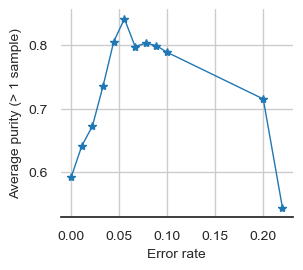

In [39]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.avg_purity_more_than_one_sample.plot(marker='*', lw=1)
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Average purity (> 1 sample)')

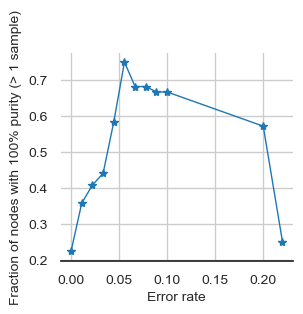

In [34]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.frac_purity_100_more_than_one_sample.plot(marker='*', lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Fraction of nodes with 100% purity (> 1 sample)')
    #plt.xscale('log')

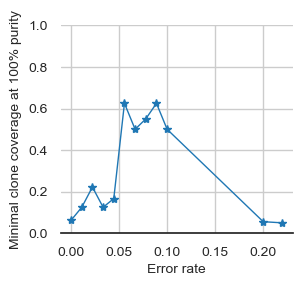

In [35]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.min_clone_coverage.plot(marker='*', lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Minimal clone coverage at 100% purity')
    #plt.xscale('log')
    plt.ylim(0, 1)

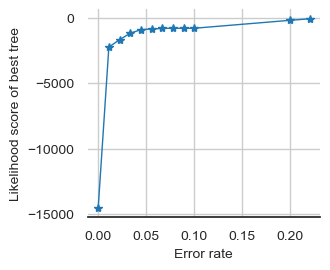

In [36]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.lhood.plot(marker='*', lw=1)
    plt.grid(axis='both')
    plt.xlabel('Error rate')
    plt.ylabel('Likelihood score of best tree')

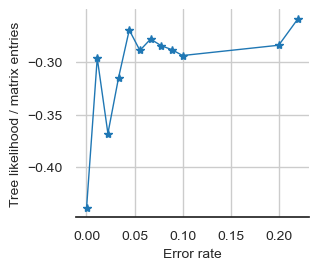

In [37]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.lhood_entries.plot(marker='*', lw=1)
    plt.grid(axis='both')
    #plt.xscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Tree likelihood / matrix entries')
    #plt.savefig('../../data/P9855_figures/P9855_lhood_entries.svg', dpi=300, bbox_inches='tight', transparent=True)

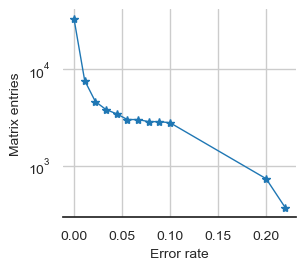

In [38]:
with plot_style(figsize=(3, 2.7), ticklabelsize=10, labelsize=10):
    performance.entries.plot(marker='*', lw=1)
    plt.grid(axis='both')
    plt.yscale('log')
    plt.xlabel('Error rate')
    plt.ylabel('Matrix entries')
    plt.savefig('../../data/P9855_figures/P9855_entries.svg', dpi=300, bbox_inches='tight', transparent=True)
    #plt.savefig('figs/performance/train_atac_log_lhood.png', dpi=300)